## First training
In this notebook, we will implement a simple training pipeline on a small
version of the adapted UNet architecture that you discovered in the
introduction.


### Load datasets
As for the previous notebook, we need to load the datasets.


In [1]:
import os
from utils.dataset import load_dataset
# Define paths
base_dir = os.path.join('/floyd', 'input', 'dlssus')
data_dir = os.path.join(base_dir, 'datasets')
# Load reduced dataset
dataset_size = 60
dataset_path = os.path.join(data_dir, 'dlssus-rf-dataset.h5')
data_lq, data_hq = load_dataset(path=dataset_path, size=dataset_size)
# Load test set
testset_path = os.path.join(data_dir, 'dlssus-rf-testset.h5')
test_lq, test_hq = load_dataset(path=testset_path)

### Create a small version of the adapted UNet
In order to create the network, we first need to compute the image shape from
the `image_axes`.
Note that the image shape is defined as lateral dimension (`x_axis`) x
axial dimension (`z_axis`) x channel number.
Since we work on grayscale images, a single channel is necessary.

In [2]:
from utils.dataset import get_dataset_axes
# Load image axes and compute image shape
image_axes = get_dataset_axes(path=dataset_path)
x_axis, z_axis = image_axes  # Unpack axes
# Compute image shape
image_shape = (x_axis.size, z_axis.size, 1)  # (H, W, C)
print('Image shape:', image_shape)

Image shape: (256, 512, 1)


We can now create a small version of the adapted UNet using the
`create_small_us_unet` available in the `models` sub-package.
This will return a Keras model that can be used right away to train.


In [8]:
from models import create_small_us_unet
model_small = create_small_us_unet(image_shape=image_shape)

Using the `model.summary()` method from the Keras API, try to analyze what
are the main differences from the full architecture presented in the
[introduction notebook][introduction].

[introduction]: dlssus_intro.ipynb


In [10]:
# Display the model summary
model_small.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 512, 16) 32          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 512, 16) 2320        conv2d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 256, 16) 0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 

**Hint:**
you can create the full network calling the `create_full_us_unet` method
and display its summary

In [ ]:
from models import create_full_us_unet
# You can try to create the full model here
from models import create_full_us_unet
model_full = create_full_us_unet(image_shape=image_shape)

### Pre-process the dataset
Before training a network on a dataset, it is recommended to normalize the
dataset to improve the training performances.
We use a standard normalization (zero mean, standard deviation one) and will
need to get the data stats.

In [11]:
from utils.dataset import get_dataset_stats
from utils.signal import normalize_data
# Get dataset stats
stats_lq, stats_hq = get_dataset_stats(path=dataset_path)
# Normalize dataset
data_lq_norm = normalize_data(data=data_lq, stats=stats_lq)
data_hq_norm = normalize_data(data=data_hq, stats=stats_hq)

### Training pipeline
For the training, we will use again the Keras API using the `model.fit()`
method as you already did yesterday.

In [12]:
from tensorflow.python.keras.optimizers import Adam
# Define training settings
epoch_number = 500
batch_size = 8
learning_rate = 4e-4
validation_split = 0.2

# Training loss and optimizer
loss = 'mean_squared_error'
optimizer = Adam(lr=learning_rate)

# Compile the model
model_small.compile(optimizer=optimizer, loss=loss)

You can optionally launch the training of the following settings.
This may take a bit of time, so it depends on your interests.
We have pre-trained networks also (see below) that will highlight the most
important results.


In [13]:
# First we need to expand the last dimension to match the Keras tensor shapes
import numpy as np
data_lq_exp = data_lq_norm[..., np.newaxis]
data_hq_exp = data_hq_norm[..., np.newaxis]

# Launch training using shuffling after each epoch
hist_obj_small = model_small.fit(
    x=data_lq_exp, y=data_hq_exp,
    batch_size=batch_size, epochs=epoch_number,
    validation_split=validation_split, shuffle=True
)

# Get the history dictionary for later plotting
hist_small = hist_obj_small.history

Train on 48 samples, validate on 12 samples
Epoch 1/500
48/48 [==============================] - 6s 121ms/step - loss: 5.8593 - val_loss: 2.8853
Epoch 2/500
48/48 [==============================] - 1s 25ms/step - loss: 5.1768 - val_loss: 2.3705
Epoch 3/500
48/48 [==============================] - 1s 25ms/step - loss: 3.8821 - val_loss: 1.8511
Epoch 4/500
48/48 [==============================] - 1s 25ms/step - loss: 3.0040 - val_loss: 1.3298
Epoch 5/500
48/48 [==============================] - 1s 25ms/step - loss: 2.1657 - val_loss: 1.1617
Epoch 6/500
48/48 [==============================] - 1s 25ms/step - loss: 1.9583 - val_loss: 1.0989
Epoch 7/500
48/48 [==============================] - 1s 25ms/step - loss: 1.8598 - val_loss: 1.0584
Epoch 8/500
48/48 [==============================] - 1s 25ms/step - loss: 1.7410 - val_loss: 1.0351
Epoch 9/500
48/48 [==============================] - 1s 25ms/step - loss: 1.7101 - val_loss: 0.9949
Epoch 10/500
48/48 [==============================] - 1

### Evaluate training performances
We will now evaluate the quality of the training, first by plotting both
training and validation losses, and second predicting the reconstructed images
on the test set.

For those who didn't train the network, which is obviously not that
interesting, we provide a pre-trained model with far more epochs
that can be loaded using the `load_pretrained_model` method accessible
from the `models` subpackage.

In order to better analyze the training curves, you are encouraged to load
the pre-trained model.


In [14]:
from models import load_pretrained_model
# Load pre-trained model
train_dir = os.path.join(base_dir, 'trainings')
model_small_name = 'usunet_res_small_rf_sn00050_lr0.000400_it0200000'
model_small_path = os.path.join(train_dir, model_small_name)
model_small, hist_small, train_size = load_pretrained_model(model_small_path)

Let's now plot the train and valid losses from the `hist_small` dictionary.
You can use the `plot_histories` accessible from the `utils.plot`
sub-package.

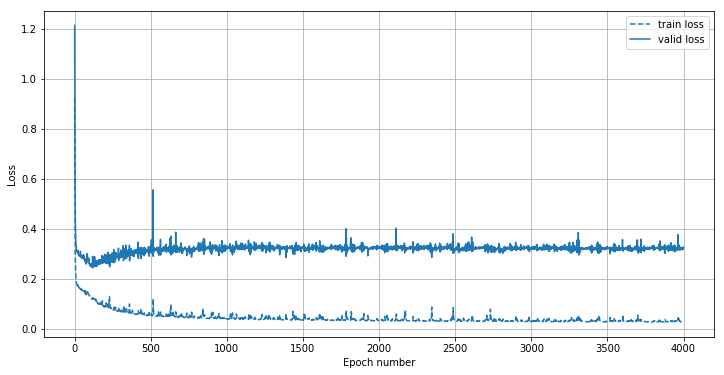

In [16]:
from utils.plot import plot_histories
plot_histories(hist_small)

From your training history we can see several things.
The training loss curve, which shows how well you network is in predicting HQ
images when provided with a training image with higher iterations is nicely
going down and starts to converge.

However, we can also see how the validation loss curve, which represents
the potency of you network to predict HQ images of images that are not inside
the training set only decreased for a few iterations and then increased again.
This is a very well-known phenomenon in machine learning, called
**over-fitting**.

It means that whatever your network learns from this point on is not
generalizable anymore and represents some kind of "learning by heart" of the
properties of your training images.
We want to avoid this at all costs.
The curves are a good example for why you should always have a validation set.

Even though many techniques exist, the most effective way to tackle
over-fitting is to simply have a larger dataset.
We will show you the effect of increasing the amount of data in the next notebook.


Even though the validation loss already tells us that the training isn't
generalized because of over-fitting, let's still have a look at the predictions
on the test images.

**Note:** Do not forget that you need to convert RF images to B-mode before
display (remember the data exploration notebook).


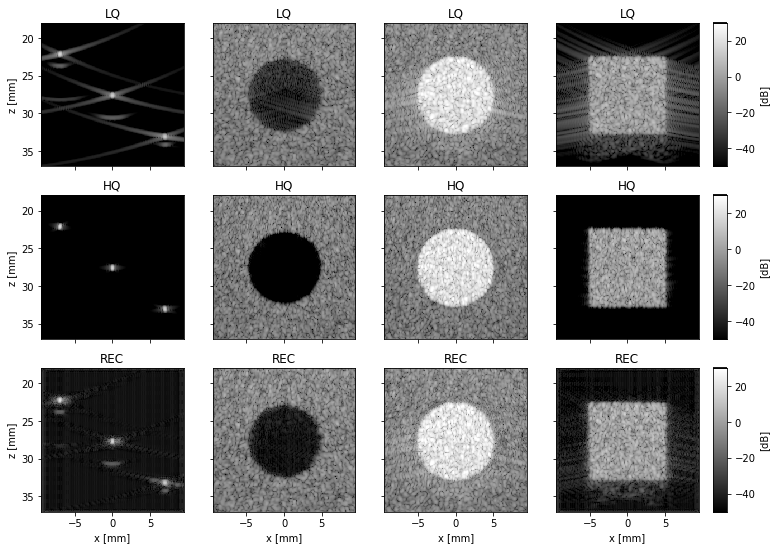

In [17]:
import numpy as np
from utils.signal import convert_to_bmode
from utils.plot import plot_image_sequences
# Expand last dimension for inference (H, W, C)
test_lq_exp = test_lq[..., np.newaxis]

# Apply network on LQ test images
test_rc = model_small.predict(test_lq_exp)

# We can now squeeze the last dimension
test_rc = test_rc.squeeze()

# Convert to B-mode before plotting (we need to squeeze the dimensions now)
test_bm_lq = convert_to_bmode(test_lq)
test_bm_rc = convert_to_bmode(test_rc)
test_bm_hq = convert_to_bmode(test_hq)

# Plots
data_range = (-50, 30)  # data-range in dB
test_seq = [test_bm_lq, test_bm_hq, test_bm_rc]
name_seq = ('LQ', 'HQ', 'REC')
plot_image_sequences(
    image_seq=test_seq, name_seq=name_seq, image_axes=image_axes,
    data_range=data_range, colorbar=True
)

As a reminder the test images are specifically designed to analyze performance,
and are not part of the training set.

We can clearly see that the achieved quality is not very good,
while some of the original image artifacts may have been reduced,
new artifacts appear and  the overall quality is hardly improved.


### So now you really deserved a coffee! Of course if you prefer you can directly head to [additional trainings][next]

[next]: dlssus_additional_trainings.ipynb

Or you can go back to the [outline].

[outline]: dlssus_main.ipynb
